# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Standard Section 10:  Feed Forward Neural Networks, Regularization, SGD Solver

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
**Section Leaders**: Marios Mattheakis, Abhimanyu (Abhi) Vasishth, Robbert (Rob) Struyven<br/>

In [122]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

The goal of this section is solve a difficult regression task and to be familiar with the regularization and with the solver that is used in neural networks (NNs).

Specifically, we will: 
  
1. Use NNs to solve a regression task where polynomial regression fails
2. Fit noise data and observe underfitting and overfitting
3. Learn about early-stopping and regularization
4. Explore the SGD solver 


#### Import packages

In [123]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
# from pandas import DataFrame

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

import copy
import operator


---------
## 1. Regression: Neuran Nets VS Polynomial Regression

We will try to fit a difficult function where polynomial regression fails. 

The dielectric function of many optical materials depends on the frequency and is given by the Lorentz model as:
$$ \varepsilon(\omega) = 1 - \frac{\omega_0^2}{\omega_0^2-\omega^2 +i\omega\Gamma},$$
where $\omega$ is the frequency, $\omega_0$ is the resonance frequency of the bound electrons, and $\Gamma$ is the electron damping. 

In many situations we measure the real part of the dielectric function in the Lab and then we want to fit the observations. Let's assume that we perform an experiment and the observations came from a Lorentz material. 

#### Lorentz model

In [7]:
def Lorentz(w,w0=1):
    Gamma = 7e-2
    eps = 1 - w0**2/(w0**2-w**2+1j*Gamma)
    return  eps.real

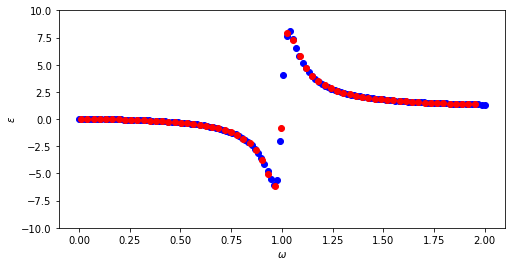

In [8]:
plt.figure(figsize=[8,4] )
w = np.linspace(0,2,128)
e = Lorentz(w)
wTest = np.linspace(0.01,1.95, 64)
eTest = Lorentz(wTest) 

plt.plot(w,e,'ob',label='Train')
plt.plot(wTest,eTest,'or',label='Test')
plt.xlabel('$\omega$')
plt.ylabel('$\epsilon$')
plt.ylim([-10,10]);

### Using polynomial regression to fit the data

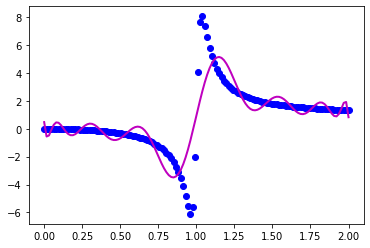

In [9]:
x = copy.copy(w)
y = copy.copy(e)

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=15)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
# print(rmse)
# print(r2)


plt.plot(x,y,'ob')
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m',linewidth=2)
plt.show()


### Using Neural Networks

#### Design the Network

In [46]:
model_1 = models.Sequential(name='LorentzModel')

# hidden layer with 20 neurons (or nodes)
model_1.add(layers.Dense(50, kernel_initializer='uniform', activation='tanh', input_shape=(1,)))
#second hidden layer with 20 neurons (or nodes)
model_1.add(layers.Dense(50, kernel_initializer='uniform', activation='tanh'))

# output layer, one neuron 
model_1.add(layers.Dense(1,  activation='linear'))

# model_t.summary()

#### Select a solver and train the NN

In [47]:
sgd = optimizers.SGD(lr=0.01, momentum=0.9)
model_1.compile(loss='MSE',optimizer=sgd) 
history_1 = model_1.fit(w, e, validation_data=(wTest,eTest), epochs=800, batch_size= 32, verbose=0) 
# history_1 = model_1.fit(w, e, epochs=800, batch_size=32, verbose=0, validation_split=.1)

#### Plot the  training and validation loss

Text(0.5, 0, 'Epoch')

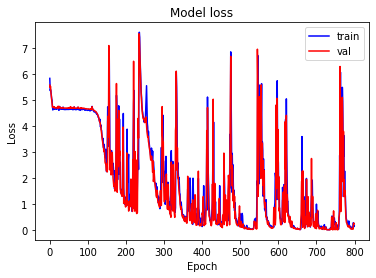

In [48]:
plt.plot(history_1.history['loss'],'b',label='train')
plt.plot(history_1.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')



#### Visualize the model prediction

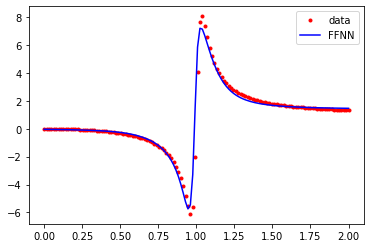

In [49]:
e_hat = model_1.predict(w)

# plot the prediction and the ground truth
plt.plot(w, e,'.r',label='data')
plt.plot(w, e_hat,'b', label='FFNN' )
plt.legend()



## 2. Noisy data, underfitting and overfitting

### In real experiments we have always noise
Hence, in reality we measure observations taken by 
$$ \varepsilon(\omega) = 1 - \frac{\omega_0^2}{\omega_0^2-\omega^2 +i\omega\Gamma} + \epsilon,$$ 
where, $\epsilon$ is white noise. 

Our goal is to discover the underlying law, namely the Lorentz model, by using neural networks.

(-13, 13)

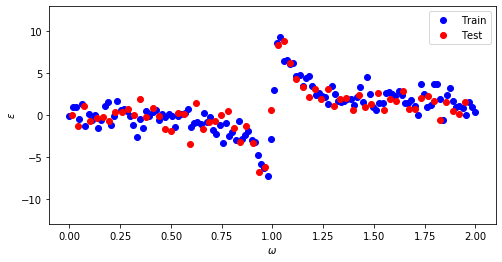

In [51]:
plt.figure(figsize=[8,4] )
Ntrain = 128
w2 = np.linspace(0,2, Ntrain)
sigNoise = 1
e2_clean = Lorentz(w2) 
e2 = e2_clean +  np.random.normal(loc=0, scale= sigNoise, size=w2.shape)



wTest2 = np.linspace(0.01,1.95, 64)
eTest2 = Lorentz(wTest) +  np.random.normal(loc=0, scale= sigNoise, size=wTest2.shape)

plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2,eTest2,'or',label='Test')
plt.legend()
plt.xlabel('$\omega$')
plt.ylabel('$\epsilon$')
plt.ylim([-13,13])

### Discover the underlying function

In [63]:
n_neurons = 50

model_2 = models.Sequential(name='noiseLorentzModel')
# first hidden layer 
model_2.add(layers.Dense(n_neurons, activation='tanh', input_shape=(1,)))
# second hidden layer 
model_2.add(layers.Dense(n_neurons, activation='tanh'))
# output layer, one neuron 
model_2.add(layers.Dense(1,  activation='linear'))
# model_t.summary()

In [64]:
sgd = optimizers.SGD(lr=0.01,momentum=0.9) 
model_2.compile(loss='MSE',optimizer=sgd) 
history_2 = model_2.fit(w2, e2, validation_data=(wTest2,eTest2), epochs=800, batch_size=32, verbose=0)

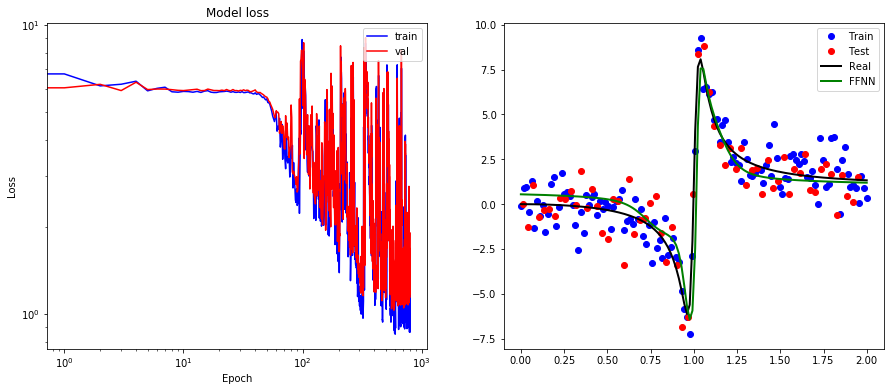

In [65]:
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.loglog(history_2.history['loss'],'b',label='train')
plt.loglog(history_2.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1,2,2)
e_hat_2 = model_2.predict(w2)

# plot the prediction and the ground truth
plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2,eTest2,'or',label='Test')
plt.plot(w2,e2_clean,'-k',label='Real', linewidth=2)
plt.plot(w2, e_hat_2,'g', label='FFNN' , linewidth=2,)

plt.legend()


### Underfitting
We use the same architecture but we train less

In [75]:
model_2_uf = models.Sequential(name='noiseLorentzModel_underFitting')

# first hidden layer 
model_2_uf.add(layers.Dense(n_neurons, activation='tanh', input_shape=(1,)))
# second hidden layer 
model_2_uf.add(layers.Dense(n_neurons, activation='tanh'))
# output layer, one neuron 
model_2_uf.add(layers.Dense(1,  activation='linear'))

sgd = optimizers.SGD(lr=0.01,momentum=0.9)
model_2_uf.compile(loss='MSE',optimizer=sgd) 
history_2_uf = model_2_uf.fit(w2, e2, validation_data=(wTest2,eTest2), epochs=300, batch_size=32, verbose=0)

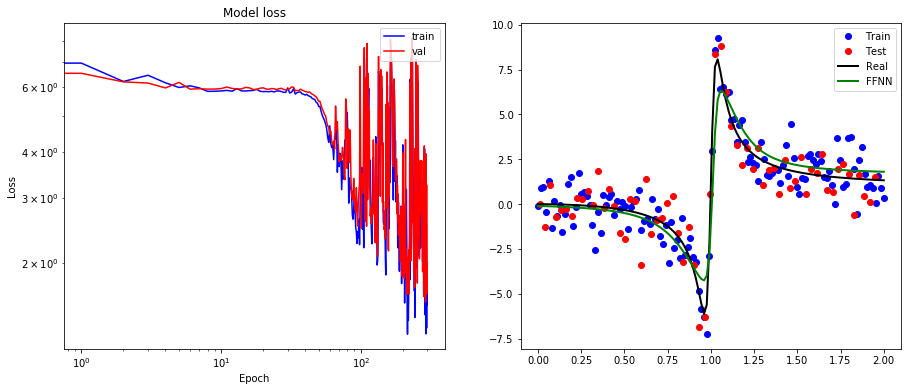

In [93]:
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.loglog(history_2_uf.history['loss'],'b',label='train')
plt.loglog(history_2_uf.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1,2,2)
e_hat_2_uf = model_2_uf.predict(w2)

# plot the prediction and the ground truth
plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2,eTest2,'or',label='Test')
plt.plot(w2,e2_clean,'-k',label='Real', linewidth=2)
plt.plot(w2, e_hat_2_uf,'g', label='FFNN' , linewidth=2,)

plt.legend()


### Overfitting
Add more neurons and train very long time. 

In [74]:
model_2_of = models.Sequential(name='noiseLorentzModel_overFitting')

# first hidden layer 
model_2_of.add(layers.Dense(n_neurons+100, activation='tanh', input_shape=(1,)))
# second hidden layer 
model_2_of.add(layers.Dense(n_neurons+100, activation='tanh'))
# output layer, one neuron 
model_2_of.add(layers.Dense(1,  activation='linear'))

sgd = optimizers.SGD(lr=0.01,momentum=0.9) 
model_2_of.compile(loss='MSE',optimizer=sgd) 
history_2_of = model_2_of.fit(w2, e2, validation_data=(wTest2,eTest2), epochs=5000, batch_size=32, verbose=0)

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fedb9f1b9e0>
Traceback (most recent call last):
  File "/home/marios/anaconda3/envs/cs109a/lib/python3.7/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 537, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/home/marios/anaconda3/envs/cs109a/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_dataset_ops.py", line 1141, in delete_iterator
    deleter)
KeyboardInterrupt: 


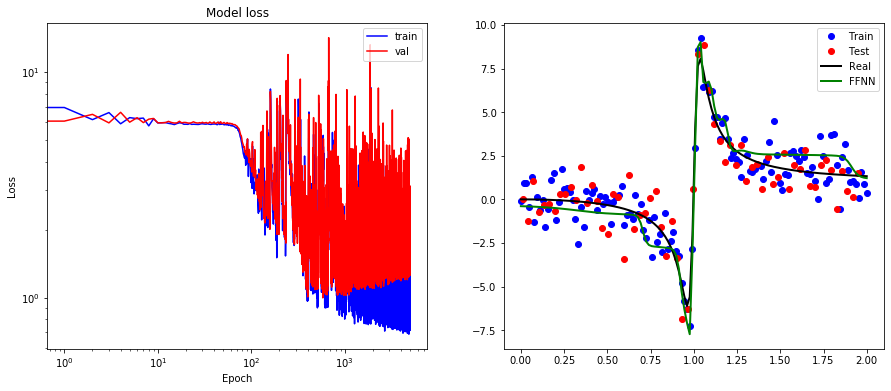

In [92]:
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.loglog(history_2_of.history['loss'],'b',label='train')
plt.loglog(history_2_of.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1,2,2)
e_hat_2_of = model_2_of.predict(w2)

# plot the prediction and the ground truth
plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2,eTest2,'or',label='Test')
plt.plot(w2,e2_clean,'-k',label='Real', linewidth=2)
plt.plot(w2, e_hat_2_of,'g', label='FFNN' , linewidth=2,)

plt.legend()


## Regularization

The easiest way to avoid overfitting is the **early-stopping** method, namely stop the training when the validation loss is minimum. *Early-stopping  does not change the model*. On the other hand *regularization  changes the model* since we change the loss function.

  Two common regularization methods are the so-called $L_1$ and $L_2$. 
- $L_1$ is trying minimize number of the network parameters and *reduces the model complexity*. In other words, it is trying to have as many zero parameters as it is possible. $L_1$ **wants the smallest number of parameters**. 
- $L_2$ is trying to minimize the value of all the parameters and have a more stable network. So, it does not care about the number of the non-zero  parameters but it cares about their values. $L_2$ **wants the parameters with small values**.


Warning! In the extreme limit of too large regularization coefficients both $L_1$ and $L_2$ lead to zero parameters. Hence,  overusing  regularization  yields  *underfitting*.

**Weight decay** is another is a another common way to regularize a network. After each update (epoch), the weights are multiplied by a factor slightly less than 1. This prevents the weights from growing too large, and can be seen as gradient descent on a quadratic regularization term. 

### $L_1$ Regularizer

In [78]:
kernel_weight = 0.003
bias_weight = 0.003

model_2_of_l1 = models.Sequential(name='noiseLorentzModel_l1')

# first hidden layer 
model_2_of_l1.add(layers.Dense(n_neurons+100, activation='tanh', input_shape=(1,)))
# second hidden layer 
model_2_of_l1.add(layers.Dense(n_neurons+100, activation='tanh', kernel_regularizer=tf.keras.regularizers.l1(kernel_weight), 
                                    bias_regularizer=tf.keras.regularizers.l1(bias_weight) ))
# output layer, one neuron 
model_2_of_l1.add(layers.Dense(1,  activation='linear'))

sgd = optimizers.SGD(lr=0.01, momentum=0.9) 
model_2_of_l1.compile(loss='MSE',optimizer=sgd) 
history_2_of_l1 = model_2_of_l1.fit(w2, e2, validation_data=(wTest2,eTest2), epochs=5000, batch_size=32, verbose=0)

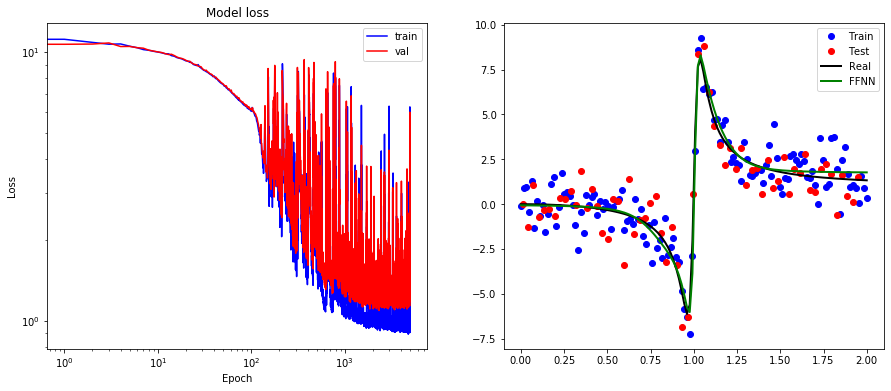

In [94]:
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.loglog(history_2_of_l1.history['loss'],'b',label='train')
plt.loglog(history_2_of_l1.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1,2,2)
e_hat_2_of_l1 = model_2_of_l1.predict(w2)

# plot the prediction and the ground truth
plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2,eTest2,'or',label='Test')
plt.plot(w2,e2_clean,'-k',label='Real', linewidth=2)
plt.plot(w2, e_hat_2_of_l1,'g', label='FFNN' , linewidth=2,)

plt.legend()


### $L_2$ Regularizer

In [80]:
kernel_weight = 0.003
bias_weight = 0.003

model_2_of_l2 = models.Sequential(name='noiseLorentzModel_l2')

# first hidden layer 
model_2_of_l2.add(layers.Dense(n_neurons+100, activation='tanh', input_shape=(1,)))
# second hidden layer 
model_2_of_l2.add(layers.Dense(n_neurons+100, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(kernel_weight), 
                                    bias_regularizer=tf.keras.regularizers.l2(bias_weight) ))
# output layer, one neuron 
model_2_of_l2.add(layers.Dense(1,  activation='linear'))

sgd = optimizers.SGD(lr=0.01,momentum=0.9) 
model_2_of_l2.compile(loss='MSE',optimizer=sgd) 
history_2_of_l2 = model_2_of_l2.fit(w2, e2, validation_data=(wTest2,eTest2), epochs=5000, batch_size=32, verbose=0)

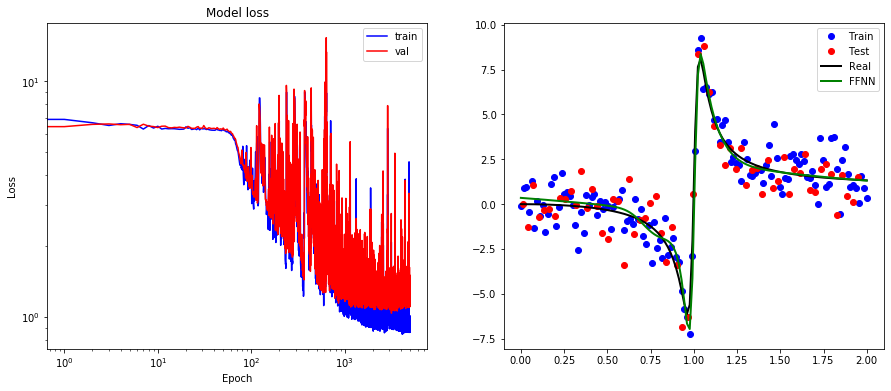

In [95]:
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.loglog(history_2_of_l2.history['loss'],'b',label='train')
plt.loglog(history_2_of_l2.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1,2,2)
e_hat_2_of_l2 = model_2_of_l2.predict(w2)

# plot the prediction and the ground truth
plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2,eTest2,'or',label='Test')
plt.plot(w2,e2_clean,'-k',label='Real', linewidth=2)
plt.plot(w2, e_hat_2_of_l2,'g', label='FFNN' , linewidth=2,)

plt.legend()


### Underfitting through Regularization

In [83]:
kernel_weight = 1
bias_weight = 1

model_2_of_l2_uf = models.Sequential(name='noiseLorentzModel_l2_uf')

# first hidden layer 
model_2_of_l2_uf.add(layers.Dense(n_neurons+100, activation='tanh', input_shape=(1,)))
# second hidden layer 
model_2_of_l2_uf.add(layers.Dense(n_neurons+100, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(kernel_weight), 
                                    bias_regularizer=tf.keras.regularizers.l2(bias_weight) ))
# output layer, one neuron 
model_2_of_l2_uf.add(layers.Dense(1,  activation='linear'))

sgd = optimizers.SGD(lr=0.01,momentum=0.9, ) 
model_2_of_l2_uf.compile(loss='MSE',optimizer=sgd) 
history_2_of_l2_uf = model_2_of_l2_uf.fit(w2, e2, validation_data=(wTest2,eTest2), epochs=5000, batch_size=32, verbose=0)

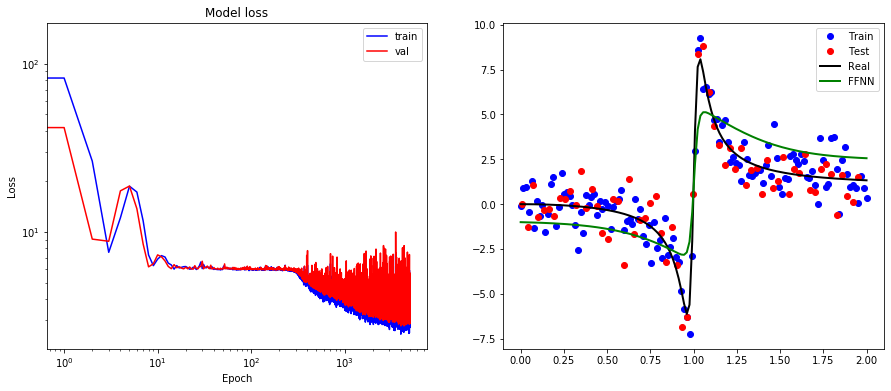

In [96]:
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.loglog(history_2_of_l2_uf.history['loss'],'b',label='train')
plt.loglog(history_2_of_l2_uf.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1,2,2)
e_hat_2_of_l2_uf = model_2_of_l2_uf.predict(w2)

# plot the prediction and the ground truth
plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2,eTest2,'or',label='Test')
plt.plot(w2,e2_clean,'-k',label='Real', linewidth=2)
plt.plot(w2, e_hat_2_of_l2_uf,'g', label='FFNN' , linewidth=2,)

plt.legend()


In [86]:
w_l1 = model_2_of_l2_uf.get_weights()
print(w_l1)


[array([[-2.88417112e-07,  1.27527655e-05, -1.16637480e-07,
         1.27158529e-07, -4.84074462e-07,  1.43536795e-06,
        -6.86162548e-06, -1.04252172e-06, -2.55289251e-06,
        -3.07931236e-06,  3.92774746e-06,  4.16653438e-06,
         1.18414084e-06, -2.58007901e-07, -2.13642478e+00,
         2.44120292e-06, -8.36712161e-07, -9.88112902e-07,
        -9.44330736e-07, -1.05971071e-06,  1.96455017e-06,
        -1.45048972e-07, -3.33212574e-06, -4.09947489e-07,
        -2.95707082e-06,  1.24698761e-06, -3.00997317e-06,
        -1.00888576e-06,  1.24241026e-07, -7.72184558e-06,
        -6.22474681e-06, -2.13643265e+00,  1.23318694e-06,
         2.50667017e-06,  1.11350982e-06, -1.76371100e-06,
        -2.08186165e-07,  8.18114495e-06, -8.95465348e-07,
        -2.61973163e-08,  5.01561495e-08, -3.92719448e-06,
         2.29828856e-07, -3.77010508e-07, -5.46358422e-07,
         2.74788044e-06,  2.31198260e-06,  1.33440528e-06,
         4.40988288e-07,  3.49153220e-06, -1.82652673e-

### Weight decay & clipping

In [88]:
kernel_weight = 0.003
bias_weight = 0.003

model_2_wd = models.Sequential(name='noiseLorentzModel_sgd_weightdecay')

# first hidden layer 
model_2_wd.add(layers.Dense(n_neurons+100, activation='tanh', input_shape=(1,)))
# second hidden layer 
model_2_wd.add(layers.Dense(n_neurons+100, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(kernel_weight), 
                                    bias_regularizer=tf.keras.regularizers.l2(bias_weight) ))
# output layer, one neuron 
model_2_wd.add(layers.Dense(1,  activation='linear'))

sgd = optimizers.SGD(lr=0.01,momentum=0.9, clipvalue=0.5, decay=1e-3)
model_2_wd.compile(loss='MSE',optimizer=sgd) 
history_2_wd = model_2_wd.fit(w2, e2, validation_data=(wTest2,eTest2), epochs=5000, batch_size=32, verbose=0)


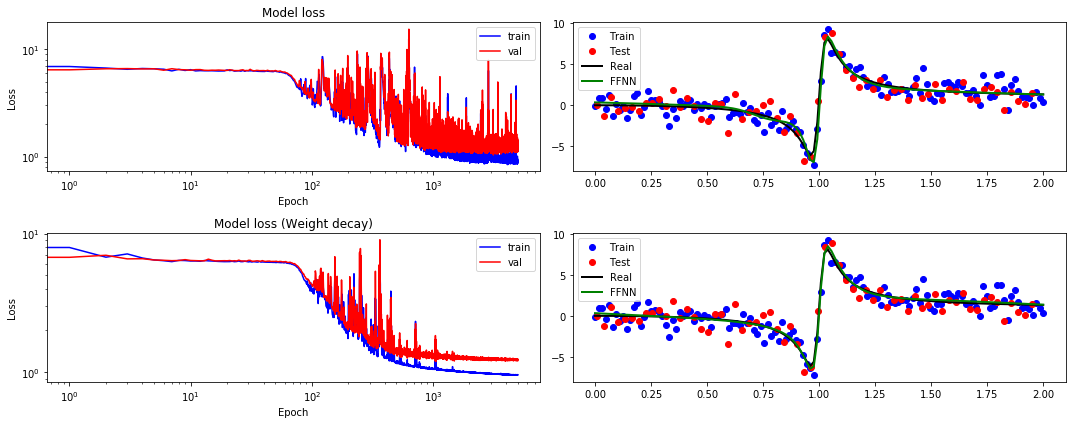

In [98]:

plt.figure(figsize=[15,6])
plt.subplot(2,2,1)
plt.loglog(history_2_of_l2.history['loss'],'b',label='train')
plt.loglog(history_2_of_l2.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(2,2,2)
e_hat_2_of_l2 = model_2_of_l2.predict(w2)

plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2,eTest2,'or',label='Test')
plt.plot(w2,e2_clean,'-k',label='Real', linewidth=2)
plt.plot(w2, e_hat_2_of_l2,'g', label='FFNN' , linewidth=2,)

plt.legend()


plt.subplot(2,2,3)
plt.loglog(history_2_wd.history['loss'],'b',label='train')
plt.loglog(history_2_wd.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss (Weight decay)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(2,2,4)
e_hat_2_wd = model_2_wd.predict(w2)

# plot the prediction and the ground truth
plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2,eTest2,'or',label='Test')
plt.plot(w2,e2_clean,'-k',label='Real', linewidth=2)
plt.plot(w2, e_hat_2_wd,'g', label='FFNN' , linewidth=2)

plt.legend()
plt.tight_layout()

## Explore the SGD solver
Exploration

- Learning rate
- Momentum
- Number of minibatches




In [104]:
kernel_weight = 0.003
bias_weight = 0.003

model_3 = models.Sequential(name='noiseLorentzModel_sgd')

# first hidden layer 
model_3.add(layers.Dense(n_neurons, activation='tanh', input_shape=(1,)))
# second hidden layer 
model_3.add(layers.Dense(n_neurons, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(kernel_weight), 
                                    bias_regularizer=tf.keras.regularizers.l2(bias_weight) ))
# output layer, one neuron 
model_3.add(layers.Dense(1,  activation='linear'))

sgd = optimizers.SGD(lr=0.01,momentum=0.9)
model_3.compile(loss='MSE',optimizer=sgd) 
history_3 = model_3.fit(w2, e2, validation_data=(wTest2,eTest2), epochs=2000, batch_size=32, verbose=0)

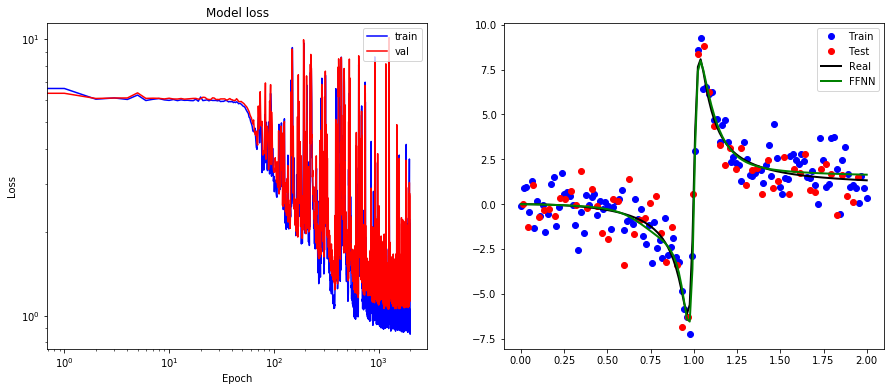

In [105]:
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.loglog(history_3.history['loss'],'b',label='train')
plt.loglog(history_3.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1,2,2)
e_hat_3 = model_3.predict(w2)

# plot the prediction and the ground truth
plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2,eTest2,'or',label='Test')
plt.plot(w2,e2_clean,'-k',label='Real', linewidth=2)
plt.plot(w2, e_hat_3,'g', label='FFNN' , linewidth=2,)

plt.legend()


### Learning Rate

### Too large learning rate

In [106]:
kernel_weight = 0.003
bias_weight = 0.003

model_3_lrL = models.Sequential(name='noiseLorentzModel_sgd_learningRate_Large')

# first hidden layer 
model_3_lrL.add(layers.Dense(n_neurons, activation='tanh', input_shape=(1,)))
# second hidden layer 
model_3_lrL.add(layers.Dense(n_neurons, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(kernel_weight), 
                                    bias_regularizer=tf.keras.regularizers.l2(bias_weight) ))
# output layer, one neuron 
model_3_lrL.add(layers.Dense(1,  activation='linear'))

sgd = optimizers.SGD(lr=0.07,momentum=0.9)
model_3_lrL.compile(loss='MSE',optimizer=sgd) 
history_3_lrL = model_3_lrL.fit(w2, e2, validation_data=(wTest2,eTest2), epochs=2000, batch_size=32, verbose=0)

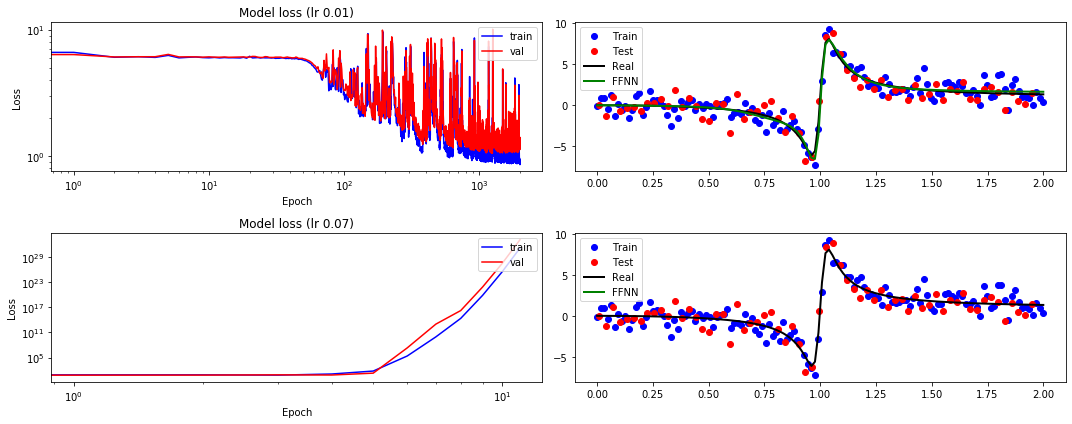

In [115]:
plt.figure(figsize=[15,6])
plt.subplot(2,2,1)
plt.loglog(history_3.history['loss'],'b',label='train')
plt.loglog(history_3.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss (lr 0.01)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(2,2,2)
plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2,eTest2,'or',label='Test')
plt.plot(w2,e2_clean,'-k',label='Real', linewidth=2)
plt.plot(w2, e_hat_3,'g', label='FFNN' , linewidth=2,)

plt.legend()

plt.subplot(2,2,3)
plt.loglog(history_3_lrL.history['loss'],'b',label='train')
plt.loglog(history_3_lrL.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss (lr 0.07)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(2,2,4)
e_hat_3_lrL = model_3_lrL.predict(w2)

# plot the prediction and the ground truth
plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2,eTest2,'or',label='Test')
plt.plot(w2,e2_clean,'-k',label='Real', linewidth=2)
plt.plot(w2, e_hat_3_lrL,'g', label='FFNN' , linewidth=2)

plt.legend()
plt.tight_layout()

### Too small learning rate

In [108]:
kernel_weight = 0.003
bias_weight = 0.003

model_3_lrS = models.Sequential(name='noiseLorentzModel_sgd_learningRate_Small')

# first hidden layer 
model_3_lrS.add(layers.Dense(n_neurons, activation='tanh', input_shape=(1,)))
# second hidden layer 
model_3_lrS.add(layers.Dense(n_neurons, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(kernel_weight), 
                                    bias_regularizer=tf.keras.regularizers.l2(bias_weight) ))
# output layer, one neuron 
model_3_lrS.add(layers.Dense(1,  activation='linear'))

sgd = optimizers.SGD(lr=0.002,momentum=0.9)
model_3_lrS.compile(loss='MSE',optimizer=sgd) 
history_3_lrS = model_3_lrS.fit(w2, e2, validation_data=(wTest2,eTest2), epochs=2000, batch_size=32, verbose=0)

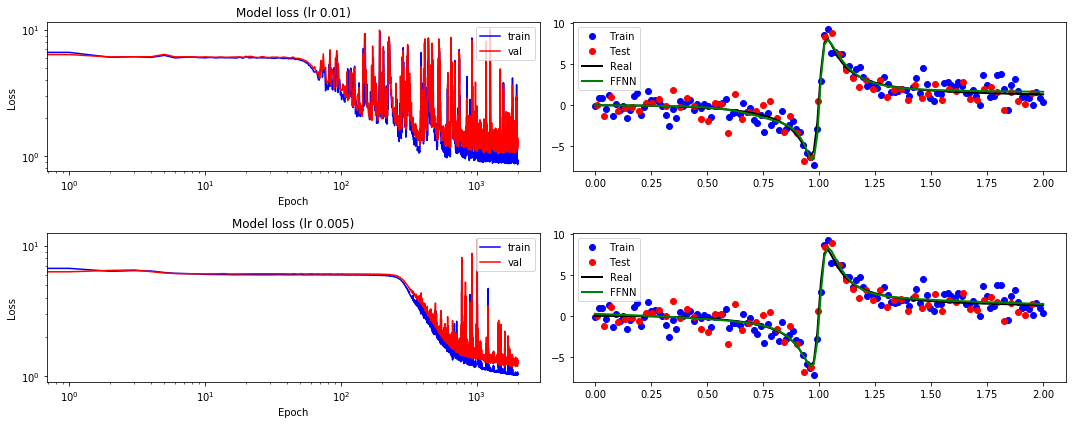

In [116]:
plt.figure(figsize=[15,6])
plt.subplot(2,2,1)
plt.loglog(history_3.history['loss'],'b',label='train')
plt.loglog(history_3.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss (lr 0.01)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(2,2,2)
plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2,eTest2,'or',label='Test')
plt.plot(w2,e2_clean,'-k',label='Real', linewidth=2)
plt.plot(w2, e_hat_3,'g', label='FFNN' , linewidth=2,)

plt.legend()

plt.subplot(2,2,3)
plt.loglog(history_3_lrS.history['loss'],'b',label='train')
plt.loglog(history_3_lrS.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss (lr 0.005)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(2,2,4)
e_hat_3_lrS = model_3_lrS.predict(w2)

# plot the prediction and the ground truth
plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2,eTest2,'or',label='Test')
plt.plot(w2,e2_clean,'-k',label='Real', linewidth=2)
plt.plot(w2, e_hat_3_lrS,'g', label='FFNN' , linewidth=2)

plt.legend()
plt.tight_layout()

### Momentum

In [110]:
kernel_weight = 0.003
bias_weight = 0.003

model_3_mn = models.Sequential(name='noiseLorentzModel_sgd_momentum')

# first hidden layer 
model_3_mn.add(layers.Dense(n_neurons, activation='tanh', input_shape=(1,)))
# second hidden layer 
model_3_mn.add(layers.Dense(n_neurons, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(kernel_weight), 
                                    bias_regularizer=tf.keras.regularizers.l2(bias_weight) ))
# output layer, one neuron 
model_3_mn.add(layers.Dense(1,  activation='linear'))

sgd = optimizers.SGD(lr=0.01,momentum=0.5)
model_3_mn.compile(loss='MSE',optimizer=sgd) 
history_3_mn = model_3_mn.fit(w2, e2, validation_data=(wTest2,eTest2), epochs=2000, batch_size=32, verbose=0)

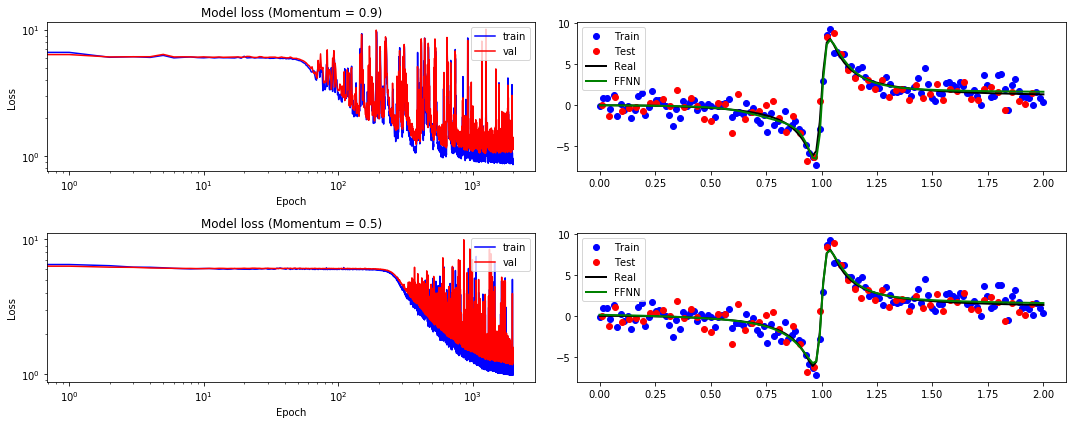

In [117]:
plt.figure(figsize=[15,6])
plt.subplot(2,2,1)
plt.loglog(history_3.history['loss'],'b',label='train')
plt.loglog(history_3.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss (Momentum = 0.9)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(2,2,2)
# plot the prediction and the ground truth
plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2,eTest2,'or',label='Test')
plt.plot(w2,e2_clean,'-k',label='Real', linewidth=2)
plt.plot(w2, e_hat_3,'g', label='FFNN' , linewidth=2)

plt.legend()
plt.tight_layout()

## 

plt.subplot(2,2,3)
plt.loglog(history_3_mn.history['loss'],'b',label='train')
plt.loglog(history_3_mn.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss (Momentum = 0.5)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(2,2,4)
e_hat_3_mn = model_3_mn.predict(w2)

# plot the prediction and the ground truth
plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2,eTest2,'or',label='Test')
plt.plot(w2,e2_clean,'-k',label='Real', linewidth=2)
plt.plot(w2, e_hat_3_mn,'g', label='FFNN' , linewidth=2)

plt.legend()
plt.tight_layout()

### Batching

#### Very large batch_size

In [113]:
kernel_weight = 0.003
bias_weight = 0.003

model_3_b1 = models.Sequential(name='noiseLorentzModel_sgd_batching1')

# first hidden layer 
model_3_b1.add(layers.Dense(n_neurons, activation='tanh', input_shape=(1,)))
# second hidden layer 
model_3_b1.add(layers.Dense(n_neurons, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(kernel_weight), 
                                    bias_regularizer=tf.keras.regularizers.l2(bias_weight) ))
# output layer, one neuron 
model_3_b1.add(layers.Dense(1,  activation='linear'))

sgd = optimizers.SGD(lr=0.01,momentum=0.9, clipvalue=0.5)
model_3_b1.compile(loss='MSE',optimizer=sgd) 
history_3_b1 = model_3_b1.fit(w2, e2, validation_data=(wTest2,eTest2), epochs=2000, batch_size=Ntrain, verbose=0)


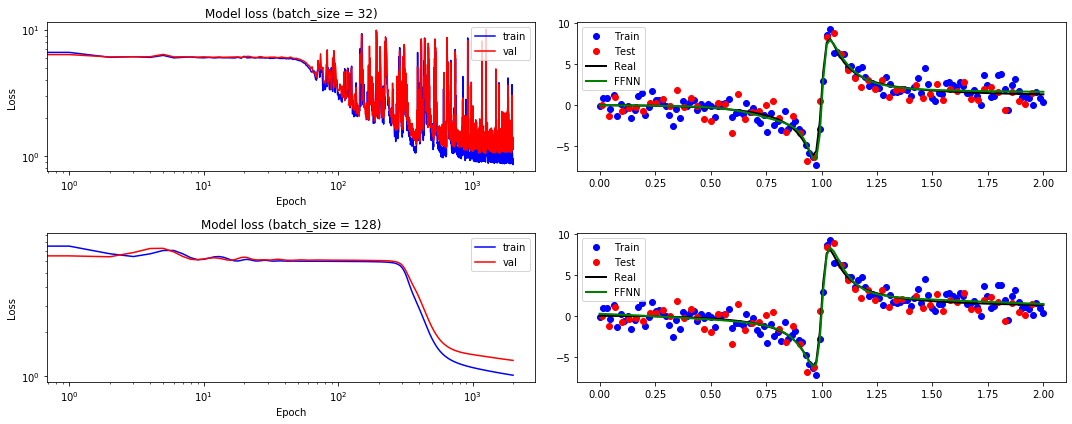

In [118]:
plt.figure(figsize=[15,6])
plt.subplot(2,2,1)
plt.loglog(history_3.history['loss'],'b',label='train')
plt.loglog(history_3.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss (batch_size = 32)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(2,2,2)
# plot the prediction and the ground truth
plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2,eTest2,'or',label='Test')
plt.plot(w2,e2_clean,'-k',label='Real', linewidth=2)
plt.plot(w2, e_hat_3,'g', label='FFNN' , linewidth=2)

plt.legend()
plt.tight_layout()


## 

plt.subplot(2,2,3)
plt.loglog(history_3_b1.history['loss'],'b',label='train')
plt.loglog(history_3_b1.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss (batch_size = 128)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(2,2,4)
e_hat_3_b1 = model_3_b1.predict(w2)

# plot the prediction and the ground truth
plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2,eTest2,'or',label='Test')
plt.plot(w2,e2_clean,'-k',label='Real', linewidth=2)
plt.plot(w2, e_hat_3_b1,'g', label='FFNN' , linewidth=2)

plt.legend()
plt.tight_layout()

#### Very small batch_size (Too SLOW)

In [119]:
kernel_weight = 0.003
bias_weight = 0.003

model_3_bs = models.Sequential(name='noiseLorentzModel_sgd_batchingSmall')

# first hidden layer 
model_3_bs.add(layers.Dense(n_neurons, activation='tanh', input_shape=(1,)))
# second hidden layer 
model_3_bs.add(layers.Dense(n_neurons, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(kernel_weight), 
                                    bias_regularizer=tf.keras.regularizers.l2(bias_weight) ))
# output layer, one neuron 
model_3_bs.add(layers.Dense(1,  activation='linear'))

sgd = optimizers.SGD(lr=0.01,momentum=0.9)
model_3_bs.compile(loss='MSE',optimizer=sgd) 
history_3_bs = model_3_bs.fit(w2, e2, validation_data=(wTest2,eTest2), epochs=2000, batch_size=8, verbose=0)


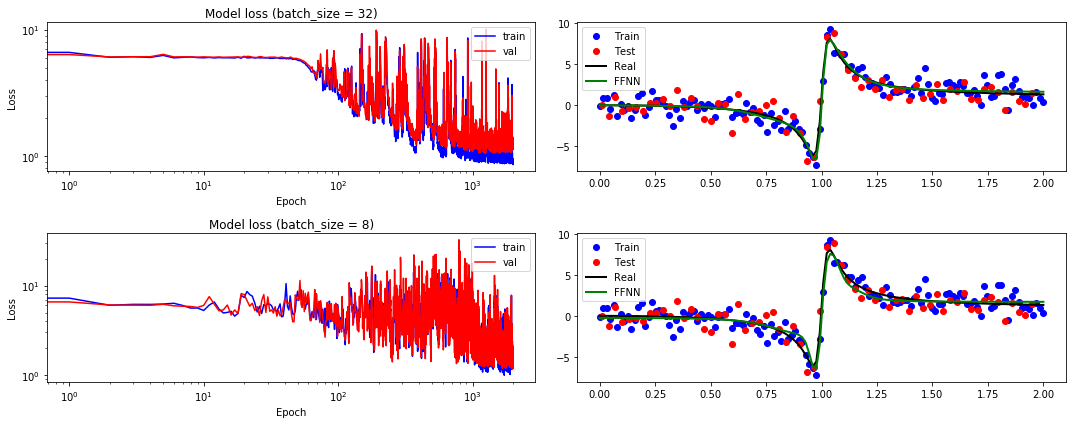

In [121]:
plt.figure(figsize=[15,6])
plt.subplot(2,2,1)
plt.loglog(history_3.history['loss'],'b',label='train')
plt.loglog(history_3.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss (batch_size = 32)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(2,2,2)
# plot the prediction and the ground truth
plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2, eTest2,'or',label='Test')
plt.plot(w2,e2_clean,'-k',label='Real', linewidth=2)
plt.plot(w2, e_hat_3,'g', label='FFNN' , linewidth=2)

plt.legend()
plt.tight_layout()


## 

plt.subplot(2,2,3)
plt.loglog(history_3_bs.history['loss'],'b',label='train')
plt.loglog(history_3_bs.history['val_loss'],'r', label='val')
plt.legend(loc='upper right')

plt.title('Model loss (batch_size = 8)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(2,2,4)
e_hat_3_bs = model_3_bs.predict(w2)

# plot the prediction and the ground truth
plt.plot(w2,e2,'ob',label='Train')
plt.plot(wTest2, eTest2,'or',label='Test')
plt.plot(w2,e2_clean,'-k',label='Real', linewidth=2)
plt.plot(w2, e_hat_3_bs,'g', label='FFNN' , linewidth=2)

plt.legend()
plt.tight_layout()


----------




## End of Section

----------